<a href="https://colab.research.google.com/github/Untick/Usedesk/blob/main/Gritsenko%20Ilia/usedesk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подгрузка датасета

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
sheet_id = "1cCjgzBbSsBnzEfRQ9NgIv_ZVjmRywoqV"
data = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv")

In [3]:
display(data[:3])

,#NAME?,comp_id_new,месяц_desc,дата,рейтинг,всего,есть ответ,выполнен,закрыт,nps,...,u-task,u_problem,u_incident,u_low,u_medium,u_urgent,u_extreme,licens,бз,бз_ст
0,#NAME?,1,1,01.06.2023,2,3709,3442,578,2466,1231,...,0,0,0,0,2,0,0,13,1,4
1,#NAME?,1,2,01.05.2023,2,5573,5301,36,4715,2004,...,0,0,0,0,5,0,0,13,1,4
2,#NAME?,1,3,01.04.2023,2,6138,5983,4,5496,2242,...,0,0,0,0,1,0,0,13,1,4


# Исследование

In [4]:
# Количество непустых ячеек и тип данных в каждом столбце
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11779 entries, 0 to 11778
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   #NAME?                  11779 non-null  object
 1   comp_id_new             11779 non-null  int64 
 2   месяц_desc              11779 non-null  int64 
 3   дата                    11779 non-null  object
 4   рейтинг                 11779 non-null  int64 
 5   всего                   11779 non-null  int64 
 6   есть ответ              11779 non-null  int64 
 7   выполнен                11779 non-null  int64 
 8   закрыт                  11779 non-null  int64 
 9   nps                     11779 non-null  int64 
 10  email                   11779 non-null  int64 
 11  telephony               11779 non-null  int64 
 12  api                     11779 non-null  int64 
 13  usedesk_chat            11779 non-null  int64 
 14  vk                      11779 non-null  int64 
 15  te

In [5]:
# Количество строк и столбцов - (11779, 55)
data.shape

(11779, 55)

In [6]:
# Количество ячеек - 647845
data.size

647845

In [7]:
# Количество пустых записей в каждом столбце
data.isna().sum()

#NAME?                    0
comp_id_new               0
месяц_desc                0
дата                      0
рейтинг                   0
всего                     0
есть ответ                0
выполнен                  0
закрыт                    0
nps                       0
email                     0
telephony                 0
api                       0
usedesk_chat              0
vk                        0
telegram                  0
whatsapp                  0
fb_instagram              0
chat                      0
instagram                 0
facebook                  0
pact_telegram_personal    0
twitter-mention           0
chat2desk                 0
slack_thread              0
twitter-direct            0
question                  0
task                      0
problem                   0
incident                  0
low                       0
medium                    0
urgent                    0
extreme                   0
агент+                    0
агент-              

# Корреляция

In [26]:
# Поиск столбцов, которые больше всего коррелируют со столбцом "рейтинг" - показывающим статус сотрудничества компании

data_corr = data.corr(method='kendall')['рейтинг']
masked_data_corr = data_corr[data_corr > 0.15]
display(masked_data_corr)

<ipython-input-26-950e1bb1836c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr = data.corr(method='kendall')['рейтинг']


рейтинг         1.000000
всего           0.183741
есть ответ      0.187318
закрыт          0.189610
telephony       0.157351
question        0.174723
medium          0.175541
правила_cnt     0.160198
правила_dist    0.152124
licens          0.192411
Name: рейтинг, dtype: float64

**Вывод**: для построения НС целесообразно использовать 4 столбца: "**licens**", **всего**", "**есть ответ**" и "**закрыт**"

# Нормализация и параметризация


In [53]:
high_cor_cols = {
    'licens': data['licens'].to_numpy(),
    'всего': data['всего'].to_numpy(),
    'есть ответ': data['есть ответ'].to_numpy(),
    'закрыт': data['закрыт'].to_numpy(),
}  # todo автоматизировать выбор нужных столбцов


for k, v in high_cor_cols.items():
  scaler = MinMaxScaler()
  scaler.fit(v.reshape(-1, 1))
  high_cor_cols[k] = scaler.transform(v.reshape(-1, 1))

x_data = np.hstack(tuple(high_cor_cols.values()))

In [56]:
x_data.shape

(11779, 4)

In [44]:
CLASS_COUNT = len(data['рейтинг'].unique())
y_data = utils.to_categorical(data['рейтинг'], CLASS_COUNT)
y_data

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [45]:
x_train, x_valid_test, y_train, y_valid_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 42)
x_test, x_valid, y_test, y_valid = train_test_split(x_valid_test, y_valid_test, test_size = 0.5, random_state = 42)

# Построение НС

In [59]:
model = Sequential()

model.add(Dense(100, input_dim=11779, activation='relu'))
model.add(Dense(CLASS_COUNT, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

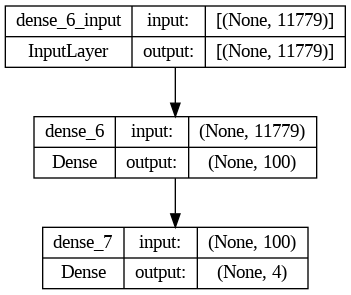

In [61]:
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# New Section

In [62]:
history = model.fit(
    x_train,
    y_train,
    validation_data = (x_valid, y_valid),
    epochs = 10,
    verbose = 1
    )

Epoch 1/10


ValueError: ignored